<a href="https://colab.research.google.com/github/ifaul/ifaul.github.io/blob/main/lang_predict12-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ian Faul, Matthew Vuong

**Predicting native languages of adult English learners from proficiency test performance**

[Link to our website](https://ifaul.github.io/)

[Link to CSV file in Drive](https://drive.google.com/file/d/1LJg6wTE_rl3WXP5lOFRoCuatc1WZjEQm/view?usp=share_link)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

pd.options.mode.copy_on_write = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks


In [3]:
#%%shell
#jupyter nbconvert --to html /content/drive/MyDrive/ColabNotebooks/lang_acquire_milestone1.ipynb

# **Project Goals**

How humans acquire new languages, and why some people are better at it than others, remains a remarkably mysterious question. While it is well-known that children are the most efficient language learners and that language-learning ability declines with age, the specific factors contributing to learning ability (age, gender, country of origin, native language, age at start of second language acquisition, etc.) are more complicated. Here, we plan on using a large dataset of close to 650,000 individuals to disentangle some of these factors. In particular, we are curious to see whether there are any patterns in performance on particular questions across various groups, which would reveal both the underlying linguistic features being tested and those that are compartively more difficult to acquire. This was something not examined by the study associated with this dataset (Hartshorne, J.K. et al, 2018); while our intention isn't to directly replicate their findings, our secondary goal is to determine whether our results converge with their conclusions.

**Collaboration plan**

We (Ian Faul and Matthew Vuong) plan on meeting weekly to discuss the project's direction and implementation, assisting each other when necessary. We will also regularly update a document tracking which steps need to be completed and who they are to be completed by to ensure that work is fairly distributed. Lastly, we will establish a shared Github respository to store our code and our updates to it, allowing us to work remotely.

# **Speakers dataset**
### **ETL**

We came across this dataset in the "Data Is Plural" archive and downloaded it from [OSF](https://osf.io/pyb8s/wiki/home/). We considered several similar datasets for this project, but this one stood out due to the large number of variables and observations, as well as its being associated with a study whose conclusions we could build on. The original dataset included the following variables:

**id** Unique subject ID

**date** Date at start of experiment

**time** Time at start of experiment

**gender**

**age**

**natlangs** List of subject's native languages

**primelangs** List of subject's primary language now

**dyslexia** Did subject report difficulty with reading?

**psychiatric** Did subject report any psychiatric disorders

**education** highest level of education

**Eng_start** age at start of English learning

**Eng_country_yrs** number of years living in English-speaking country

**house_Eng** subject lives with any native English speakers?

**dictionary** subject reported using a dictionary to complete experiment

**already_participated** Subject reported prior participation in experiment

**countries** countries lived in

**currcountry** country currently lived in

**US_region** regions of USA lived in

**UK_region** regions of UK lived in

**Can_region** regions of Canada lived in

**Ebonics** speaker of Ebonics?

**Ir_region** county of Ireland lived in

**UK_constituency** constituency of UK lived in

**nat_Eng** native speaker of English

**lived_Eng_per** Percentage of years speaking English that lived in English-speaking country.

**Eng_little** values are monoeng (native speaker of English only), bileng (native speaker of English + at least one other lang), lot (immersion learner), little (non-immersion learner).

**q1, q2, etc.** test questions, with subparts

**correct** percentage of critical items correct

**elogit** elogit of correct (not sure what this means)


While this data was originally collected for the primary purpose of finding the critical point in development where grammar-learning ability begins to decline (their finding: 17.4 years), some other specific questions this dataset allows us to consider are (1) Can the test questions be grouped into distinct types, other than the syntactic phenomena explicity included by the original researchers, based on systematic differences in performance among groups? (2) Are there systematic differences in the performance of speakers of native languages other than English? In other words, in which ways do speakers of some languages (or language groups) perform better or worse than others? (3) For people at or above the critical age found in the original study, which variables are associated with the highest overall performance or performance on specific questions/question types?

In the following section, we consider a more workable subset of 10,000 observations, removing variables likely of little relevance, creating new columns to more easily access information separated by commas in individual cells in the original data table, making values within columns consistent and of the correct data type, and lastly, tidying it up.

In [4]:
df_lang = pd.read_csv('data.csv', nrows=100001)
df_lang.head()

<ipython-input-4-a1f1fb77e63c>:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lang = pd.read_csv('data.csv', nrows=100001)


,Unnamed: 0,id,date,time,gender,age,natlangs,primelangs,dyslexia,psychiatric,...,q34_6,q34_8,q35_1,q35_2,q35_4,q35_5,q35_7,q35_8,correct,elogit
0,1,2.0,2014-05-29,01:00:55,male,31,English,English,0,0,...,1,1,1,1,1,1,1,1,0.978947,3.621671
1,2,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
2,3,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
3,4,4.0,2014-05-29,01:01:13,male,19,English,English,0,0,...,1,1,1,1,1,0,1,1,0.905263,2.208853
4,5,5.0,2014-05-29,01:01:19,male,20,"Chinese/Mandarin, English","Chinese/Mandarin, English",0,0,...,1,1,1,1,1,0,1,1,0.947368,2.800602


In [5]:
# Remove unnecessary variables
df_lang.drop(columns=['Unnamed: 0', 'date', 'time', 'US_region', 'UK_region',
                      'Can_region', 'Ir_region', 'UK_constituency', 'tests'], inplace=True)

# Remove strange values in some variables
df_lang['education'].unique() # There are some crazy values in here!

def replace_school_with_NAN(entry, allowed_list):
    if entry not in allowed_list:
        return np.nan
    return entry

# These appear to be the original choices offered in the questionnaire.
allowed_list = ['Graduate Degree', 'Undergraduate Degree (3-5 years higher ed)',
                'Some Undergrad (higher ed)', 'High School Degree (12-13 years)',
                'Some Graduate School', 'Didn''t Finish High School (less than 13 years ed)']

df_lang['education'] = df_lang['education'].apply(lambda x: replace_school_with_NAN(x, allowed_list))

# Remove duplicates
df_lang.drop_duplicates(subset=['id'], inplace=True)

Now that we have cleaned up the dataframe a bit, we can confirm that all variables are of the correct data type and correct those that are not.

In [6]:
display(df_lang[['dyslexia', 'psychiatric', 'education', 'Eng_start', 'Eng_country_yrs',
         'house_Eng', 'dictionary', 'already_participated', 'countries', 'currcountry',
         'nat_Eng', 'prime_Eng', 'speaker_cat', 'Eng_little']].dtypes) # Checking to see which data types are incorrect

df_lang[['dyslexia', 'psychiatric','dictionary',
         'already_participated','nat_Eng', 'prime_Eng']] = df_lang[['dyslexia','psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].astype('bool')
display(df_lang[['dyslexia', 'psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].dtypes) # Converting appropriate colums to bools

# Select all question columns
questions = pd.Series(df_lang.columns).str.startswith('q')
question_cols = df_lang.columns[questions]

# Convert question columns to bools
df_lang[question_cols] = df_lang[question_cols].astype('bool')
display(df_lang[question_cols].dtypes)

,0
dyslexia,int64
psychiatric,int64
education,object
Eng_start,int64
Eng_country_yrs,float64
house_Eng,float64
dictionary,int64
already_participated,int64
countries,object
currcountry,object


,0
dyslexia,bool
psychiatric,bool
dictionary,bool
already_participated,bool
nat_Eng,bool
prime_Eng,bool


,0
q1,bool
q2,bool
q3,bool
q5,bool
q6,bool
...,...
q35_2,bool
q35_4,bool
q35_5,bool
q35_7,bool


Here, we split up the natlang and primelang variables...

In [121]:
# Tidying natlangs and primelangs

df_ref_natlang = pd.concat([df_lang['natlangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_natlang = pd.melt(df_ref_natlang,id_vars=['id'],value_vars=[0,1,2,3,4]).dropna() # This dropna does drop some observations because some people put no values for natlangs. not sure if we wanted them anyway
df_ref_natlang = df_ref_natlang.drop(columns=['variable']).set_index(['id']).sort_index()

df_ref_primelang = pd.concat([df_lang['primelangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_primelang = pd.melt(df_ref_primelang,id_vars=['id'],value_vars=[0,1,2,3,4,5,6,7]).dropna() # This dropna does drop some observations because some people put no values for natlangs. not sure if we wanted them anyway
df_ref_primelang = df_ref_primelang.drop(columns=['variable']).set_index(['id']).sort_index()

# Strip whitespace
df_ref_natlang['value'] = df_ref_natlang['value'].str.strip()
df_ref_primelang['value'] = df_ref_primelang['value'].str.strip()

# Combine all forms of Chinese for simplicity (and future merging)
df_ref_natlang['value'] = df_ref_natlang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)
df_ref_primelang['value'] = df_ref_primelang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)

# Merge natlang and primelang onto new dataframe
df_linginfo_merged = pd.merge(df_ref_natlang, df_ref_primelang, on='id', how='outer').rename(columns={'value_x': 'natlang', 'value_y': 'primelang'})
df_lang_tidy = df_lang.drop(columns=['natlangs','primelangs'])
df_lang_tidy = df_lang_tidy.merge(df_linginfo_merged, on='id', how='outer')

In [124]:
# Find all values in natlang with the word chinese in them
df_lang_tidy.dropna(subset=['natlang'], inplace=True) # Drop rows with NaN values in 'natlang' column
df_lang_tidy[df_lang_tidy['natlang'].str.contains('Chinese')]['natlang'].unique()

array(['Chinese'], dtype=object)

In [125]:
# Filter df_lang_tidy by unique combinations of id and natlang
df_lang_tidy.drop_duplicates(subset=['id', 'natlang'], inplace=True)
df_lang_tidy.head()

,id,gender,age,dyslexia,psychiatric,education,Eng_start,Eng_country_yrs,house_Eng,dictionary,...,q35_1,q35_2,q35_4,q35_5,q35_7,q35_8,correct,elogit,natlang,primelang
0,2.0,male,31,False,False,Graduate Degree,0,NaN,NaN,False,...,True,True,True,True,True,True,0.978947,3.621671,English,English
1,3.0,male,30,False,True,Undergraduate Degree (3-5 years higher ed),0,NaN,NaN,False,...,True,True,True,True,True,True,1.000000,5.252273,English,English
2,4.0,male,19,False,False,Some Undergrad (higher ed),0,NaN,NaN,False,...,True,True,True,False,True,True,0.905263,2.208853,English,English
3,5.0,male,20,False,False,High School Degree (12-13 years),0,NaN,NaN,False,...,True,True,True,False,True,True,0.947368,2.800602,English,English
5,5.0,male,20,False,False,High School Degree (12-13 years),0,NaN,NaN,False,...,True,True,True,False,True,True,0.947368,2.800602,Chinese,English


### **EDA**

Here, we give some summary statistics for native and primary languages.

In [126]:
display(df_lang_tidy['natlang'].value_counts()) # Number of native languages
display(df_lang_tidy['primelang'].value_counts()) # Number of primary languages

,count
natlang,
English,44920
Finnish,22257
Chinese,6382
German,4084
Spanish,3299
...,...
Chewa,1
Sranan,1
Oykangand,1


,count
primelang,
English,62196
Finnish,17214
German,3816
Chinese,3219
Swedish,2740
...,...
Manx,1
Samoan,1
Malagasy,1


,age
count,99999.000000
mean,29.089601
std,10.527055
min,7.000000
25%,22.000000
50%,26.000000
75%,34.000000
max,89.000000


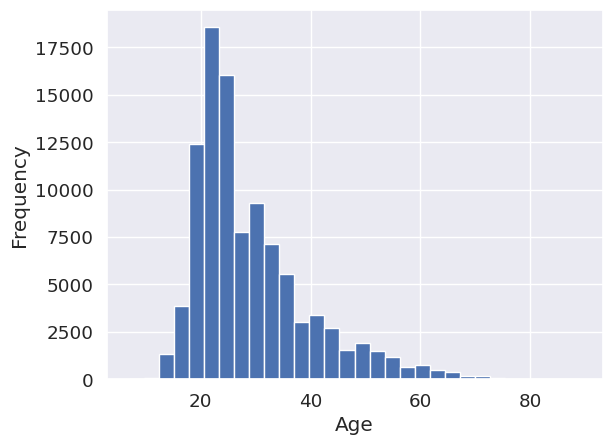

In [127]:
# Histogram of age of participants
df_lang['age'].plot.hist(xlabel='Age', bins=30)
df_lang['age'].describe()

<ipython-input-128-7f9b04d03c22>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_adult_learner['yrs_learning'] = df_adult_learner['age'] - df_adult_learner['Eng_start']


,age,Eng_start,yrs_learning
count,12769.000000,12769.000000,12769.000000
mean,32.742266,11.606234,21.136033
std,11.335041,2.914134,11.237088
min,11.000000,10.000000,1.000000
25%,24.000000,10.000000,13.000000
50%,30.000000,11.000000,19.000000
75%,38.000000,12.000000,27.000000
max,89.000000,69.000000,75.000000


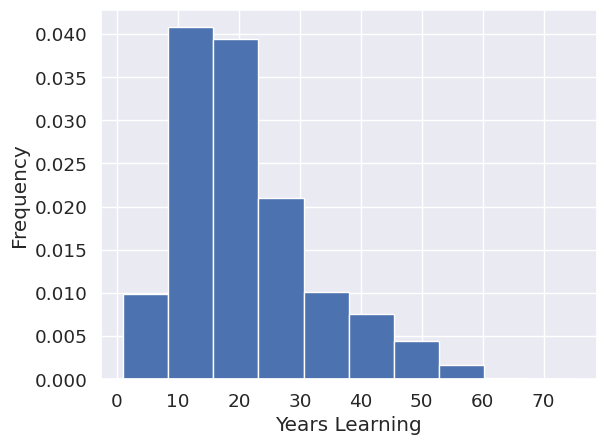

In [128]:
# Number of adult speakers who started learning English after 10 y/o, don't speak English as a primary language, and have not undergone language immersion

df_adult_learner = df_lang_tidy[df_lang_tidy['Eng_start'] >= 10]
df_adult_learner['yrs_learning'] = df_adult_learner['age'] - df_adult_learner['Eng_start']
#df_adult_learner = df_adult_learner[df_adult_learner['yrs_learning'] <= 10]
df_adult_learner = df_adult_learner[df_adult_learner['primelang'] != 'English']
df_adult_learner = df_adult_learner[df_adult_learner['Eng_little'] == 'little']

df_adult_learner['yrs_learning'].plot.hist(bins=10, xlabel='Years Learning', density=True)
df_adult_learner[['age', 'Eng_start', 'yrs_learning']].describe()

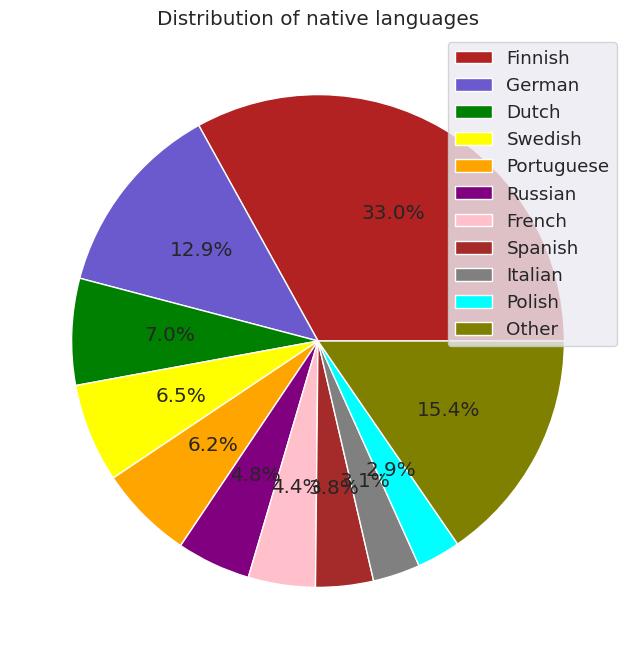

In [129]:
# Pie chart showing the percentages of non-native adult English speakers in the dataset

df_natlang_other = pd.Series(df_adult_learner['natlang'].value_counts().iloc[10:].sum(), index=['Other'])
df_natlang_pie = pd.concat([df_adult_learner['natlang'].value_counts().iloc[0:10], df_natlang_other])

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['firebrick', 'slateblue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'olive']

ax.pie(x=df_natlang_pie.values, labels=None, colors=colors, autopct='%1.1f%%')
plt.legend(df_natlang_pie.index, loc='best')
plt.title('Distribution of native languages')
plt.show()

# Features dataset

For the second milestone, we included and parsed an additional relevant dataset.

Specifically, we pulled the following dataset from the World Atlas of Language Structures Online (WALS) webpage, which has a number of datasets on structural features of various languages. The questions in the English proficiency test from the first dataset were not explicitly testing specific elements of syntactic knowledge, so we selected 30 grammatical features that seemed relevant to the test questions.

Using these features, we hope to create rough groupings of languages based on structural similarity rather than geographic similarity and assess each grouping's performance on the test questions.

### **ETL**

In [130]:
import glob

# Change to folder containing all additional CSVs:
%cd /content/drive/MyDrive/ColabNotebooks/additionalFiles

# Glob all csv files:
all_csvs = glob.glob('*.csv')

# Create base df for later merging:
df_features = pd.read_csv('genitive_noun.csv',sep='\t').drop(columns = ['description','value'])

# Iterate through list and merge dfs:
for file in all_csvs:
  # Print file name for debugging
  print(f"Processing file: {file}")

  # Read in current file and slice for non-redundant columns:
  df_current = pd.read_csv(file, sep='\t', on_bad_lines='skip')
  current_name = file[:-4] # Get name of file for df columns

  # Rename value and description columns
  df_current = df_current.rename(
      columns={
          "value": current_name + "_value",
          "description": current_name + "_description",
      }
  )

  # Select only the columns to merge
  df_current_sliced = df_current[['name', current_name + '_value', current_name + '_description']]

  # Perform the merge
  df_features = df_features.merge(df_current_sliced, on='name', how='outer')

# Drop unnecessary variables
df_features = df_features.drop(columns=['wals code', 'latitude', 'longitude', 'area'], errors='ignore') #ignore if column doesn't exist

/content/drive/MyDrive/ColabNotebooks/additionalFiles
Processing file: case_num.csv
Processing file: perfective_aspect.csv
Processing file: future_tense.csv
Processing file: indef_art.csv
Processing file: lang_order.csv
Processing file: past_tense.csv
Processing file: locus.csv
Processing file: tone.csv
Processing file: inflection.csv
Processing file: perfect.csv
Processing file: neg_morpheme.csv
Processing file: polar_q.csv
Processing file: def_art.csv
Processing file: nominal_plurality.csv
Processing file: gender_distinctions.csv
Processing file: case_syncretism.csv
Processing file: number_of_genders.csv
Processing file: case_affixes.csv
Processing file: comitatives.csv
Processing file: adposition_noun.csv
Processing file: conjunctions.csv
Processing file: epistemic_possibility.csv
Processing file: third_person_prondem.csv
Processing file: relative_noun.csv
Processing file: tense_aspect.csv
Processing file: situational_possibility.csv
Processing file: numeral_classifiers.csv
Processi

In [131]:
# Check for differences between Mandarin and Cantonese
mandarin = df_features[df_features['name'] == 'Mandarin'].reset_index(drop=True)
cantonese = df_features[df_features['name'] == 'Cantonese'].reset_index(drop=True)
mandarin.compare(cantonese)

# Combine Mandarin and Cantonese into a single observation, Chinese
df_features.loc[df_features['name'] == 'Mandarin', 'name'] = 'Chinese'
df_features.loc[df_features['name'] == 'Cantonese', 'name'] = 'Chinese'
df_features = df_features.groupby('name').first().reset_index()

# Rename other languages with inconsistent names between datasets
df_features['name'] = df_features['name'].str.replace(r'^Malay.*', 'Malay', regex=True)
df_features['name'] = df_features['name'].str.replace(r'^Greek.*', 'Greek', regex=True)
df_features['name'] = df_features['name'].str.replace(r'^Serbian.*', 'Serbian', regex=True)

Because in the WALS dataset (and not the original dataset), Arabic is broken up by regional dialect, and each dialect is significantly different grammatically, we have to drop it:

In [132]:
df_features.drop(df_features[df_features['name'] == 'Arabic'].index, inplace=True)
df_lang_tidy.drop(df_lang_tidy[df_lang_tidy['natlang'] == 'Arabic'].index, inplace=True)

We then merge the new DataFrame with the DataFrame from the previous milestone:

In [133]:
# Merge df_features with df_adult_learner on natlang
df_features = df_features.rename(columns={'name':'natlang'})
df_adult_learner = df_adult_learner.merge(df_features, how='left', on='natlang')

### **EDA**

We were interested in the distribution of language families in the dataset:

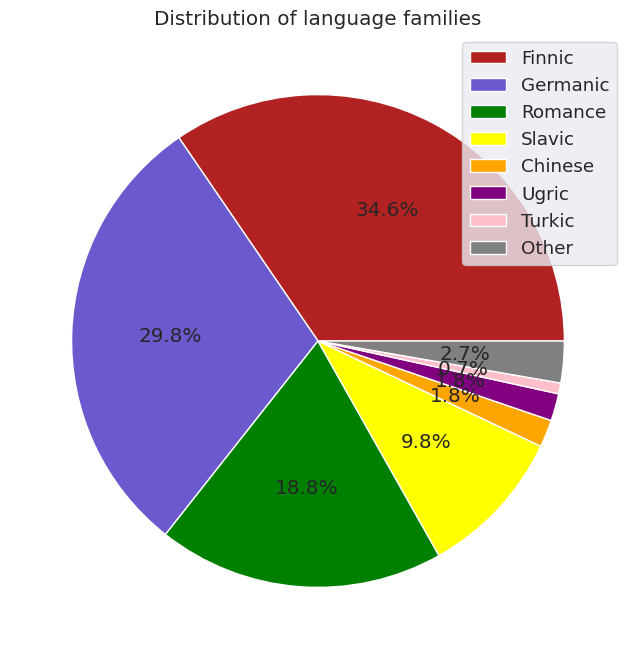

In [134]:
df_genus_other = pd.Series(df_adult_learner['genus'].value_counts().iloc[7:].sum(), index=['Other'])
df_genus_pie = pd.concat([df_adult_learner['genus'].value_counts().iloc[0:7], df_genus_other])

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['firebrick', 'slateblue', 'green', 'yellow', 'orange', 'purple', 'pink', 'gray']

ax.pie(x=df_genus_pie.values, labels=None, colors=colors, autopct='%1.1f%%')
ax.set_title('Distribution of language families')
plt.legend(df_genus_pie.index, loc='best')
plt.show()

What are the distributions of particular languages within each language family represented here?

In [135]:
df_adult_learner.groupby('genus')['natlang'].value_counts().sort_values(ascending=False)

genus                       natlang   
Finnic                      Finnish       4219
Germanic                    German        1642
                            Dutch          893
                            Swedish        829
Romance                     Portuguese     792
Slavic                      Russian        619
Romance                     French         562
                            Spanish        484
                            Italian        396
Slavic                      Polish         365
Chinese                     Chinese        222
Ugric                       Hungarian      221
Germanic                    Norwegian      144
                            Danish         116
Slavic                      Czech           87
Turkic                      Turkish         85
Japanese                    Japanese        84
Malayo-Sumbawan             Indonesian      71
Slavic                      Serbian         70
Finnic                      Estonian        56
Germanic                    Icelandic       53
Romance                     Romanian        51
Vietic                      Vietnamese      48
Romance                     Catalan         41
Slavic                      Bulgarian       40
Greek                       Greek           39
Slavic                      Slovene         30
Baltic                      Latvian         26
                            Lithuanian      21
Kam-Tai                     Thai            13
Germanic                    Frisian         12
Korean                      Korean          10
Albanian                    Albanian         8
Basque                      Basque           3
Turkic                      Tatar            3
Slavic                      Macedonian       2
Ainu                        Ainu             2
Wolof                       Wolof            2
Kartvelian                  Georgian         2
Greater Central Philippine  Tagalog          2
Burmese-Lolo                Burmese          2
Germanic                    English          1
Dravidian                   Malay            1
Barito                      Malagasy         1
Bantu                       Zulu             1
                            Swahili          1
Indic                       Marathi          1
Name: count, dtype: int64

We then computed a distance matrix to determine which languages were grammatically closest to English based on these features.

In [136]:
# Add English speakers back to the dataframe, creating the dataframe for our sample
df_lang_eng = df_lang_tidy[df_lang_tidy['natlang'] == 'English']
df_lang_eng = df_lang_tidy[df_lang_tidy['primelang'] == 'English']
df_lang_sample = df_adult_learner.merge(df_lang_eng, how='outer')

In [137]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.impute import KNNImputer

# For visualization, filter by the top 30 most common languages in the dataset
df_lang_30_index = df_lang_sample['natlang'].value_counts()[:30].index
df_features = df_features[df_features['natlang'].isin(df_lang_30_index)]

# Dummify feature variables
df_features_desc = df_features.filter(regex='_description$')
df_features_encode = pd.get_dummies(df_features_desc)

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_features_imputed = imputer.fit_transform(df_features_encode)

# Convert imputed array back to DataFrame
df_features_desc = pd.DataFrame(df_features_imputed, columns=df_features_encode.columns, index=df_features_desc.index)

# Standardize data
scaler = StandardScaler()
scaler.fit(df_features_encode)
df_features_sc = scaler.transform(df_features_encode)

D = pairwise_distances(df_features_encode, metric='euclidean')
np.fill_diagonal(D, np.nan)
df_features_sc = pd.DataFrame(D, index=df_features['natlang'], columns=df_features['natlang'])
display(df_features_sc)

natlang,Chinese,Czech,Danish,Dutch,English,Finnish,French,German,Greek,Hindi,...,Portuguese,Romanian,Russian,Serbian,Spanish,Swedish,Tagalog,Tamil,Turkish,Vietnamese
natlang,,,,,,,,,,,,,,,,,,,,,
Chinese,NaN,6.324555,5.916080,5.830952,6.403124,6.164414,6.403124,6.633250,6.324555,6.324555,...,5.567764,6.244998,6.403124,5.916080,6.164414,5.830952,6.082763,6.164414,6.480741,5.477226
Czech,6.324555,NaN,3.605551,4.472136,5.385165,5.477226,5.916080,5.477226,5.656854,5.830952,...,4.795832,4.795832,5.000000,3.605551,5.291503,4.472136,6.244998,4.898979,6.000000,6.000000
Danish,5.916080,3.605551,NaN,3.605551,4.690416,5.385165,5.291503,4.795832,5.000000,5.567764,...,4.000000,3.741657,5.291503,4.000000,4.795832,3.000000,6.324555,5.000000,5.916080,5.916080
Dutch,5.830952,4.472136,3.605551,NaN,4.358899,6.000000,5.000000,4.472136,4.690416,6.000000,...,4.123106,4.795832,5.385165,4.795832,4.242641,4.242641,6.244998,5.656854,6.480741,5.477226
English,6.403124,5.385165,4.690416,4.358899,NaN,5.916080,5.477226,4.123106,5.196152,6.244998,...,4.898979,5.099020,5.477226,5.656854,5.196152,4.123106,6.928203,6.244998,7.000000,6.403124
Finnish,6.164414,5.477226,5.385165,6.000000,5.916080,NaN,5.744563,5.477226,5.656854,4.000000,...,5.567764,5.744563,5.000000,5.196152,5.656854,5.477226,6.082763,5.291503,6.000000,6.164414
French,6.403124,5.916080,5.291503,5.000000,5.477226,5.744563,NaN,4.582576,3.872983,5.196152,...,4.242641,5.099020,4.898979,5.656854,3.605551,5.196152,6.164414,6.403124,5.916080,6.403124
German,6.633250,5.477226,4.795832,4.472136,4.123106,5.477226,4.582576,NaN,3.741657,5.830952,...,4.795832,4.795832,4.795832,5.744563,4.690416,4.472136,6.855655,5.830952,6.480741,6.480741
Greek,6.324555,5.656854,5.000000,4.690416,5.196152,5.656854,3.872983,3.741657,NaN,5.477226,...,3.872983,4.582576,4.358899,5.385165,4.472136,4.898979,6.708204,6.000000,6.000000,6.324555


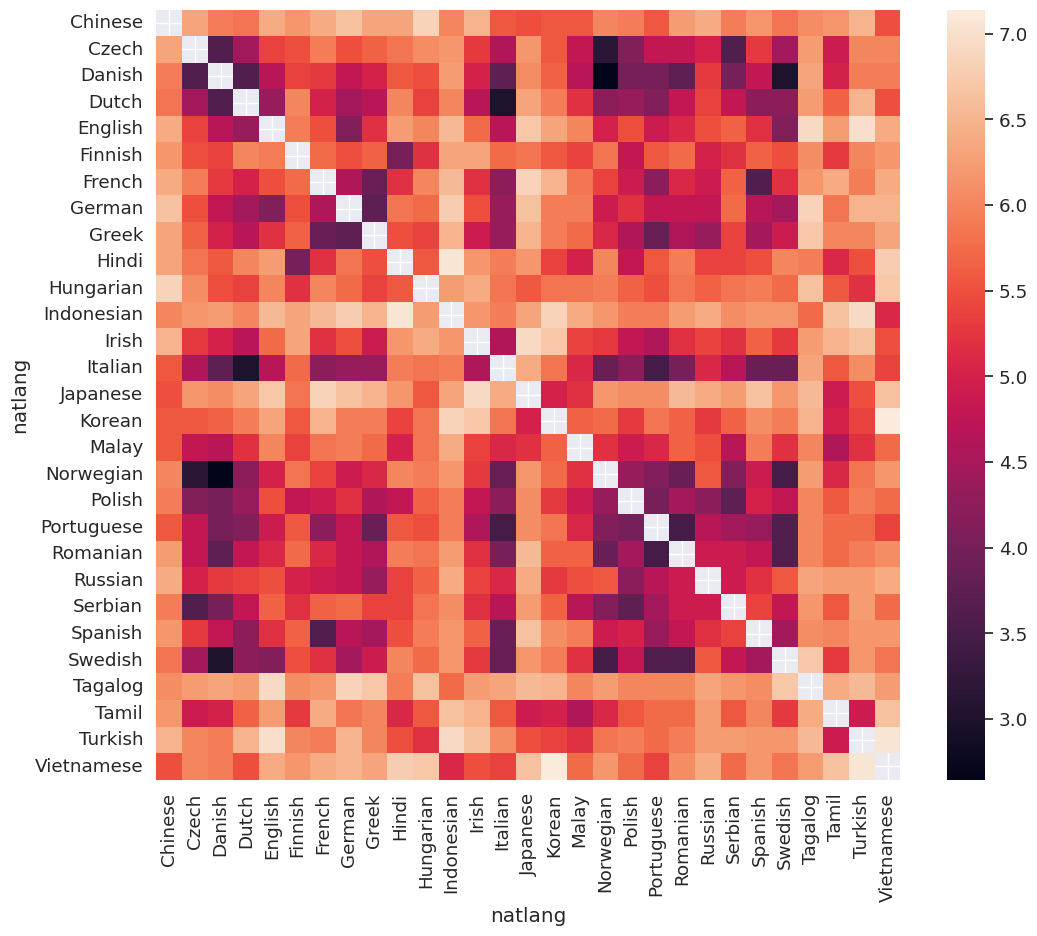

In [138]:
# Create a visualization for the distance matrix
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df_features_sc)
sns.set(font_scale=1.2)

We then calculated each language's distance from English based on the syntactic features. While there were some surprising languages, due to our including only a small number of grammatical features, the distances lined up with our intuitions well overall.

In [139]:
# Slice DataFrame for distances from English
df_eng_dist = df_features_sc['English'].sort_values()
df_eng_dist

,English
natlang,
German,4.123106
Swedish,4.123106
Dutch,4.358899
Danish,4.690416
Italian,4.690416
Portuguese,4.898979
Norwegian,5.000000
Romanian,5.099020
Spanish,5.196152


Is there a relationship between syntactic similarity to English and overall test performance among adult non-Native English speakers?

,Distance,correct
Distance,1.000000,-0.111541
correct,-0.111541,1.000000


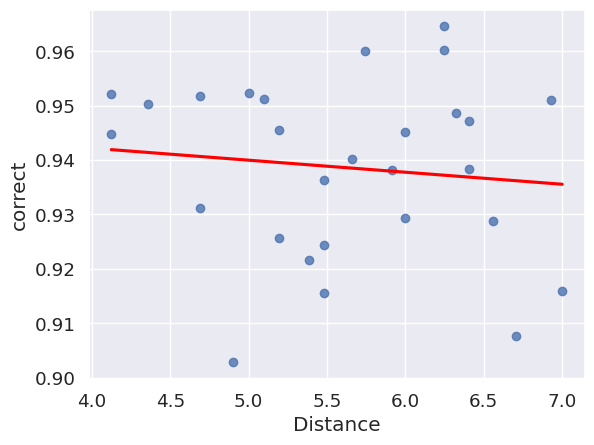

In [140]:
df_lang_30 = df_lang_sample[df_lang_sample['natlang'].isin(df_lang_30_index)]
df_30_correct = df_lang_30.groupby('natlang')['correct'].mean().sort_values(ascending=False)

# Organize alphabetically to have the same index
df_eng_dist = df_eng_dist.sort_index()
df_30_correct = df_30_correct.sort_index()

# Concatenate the two Series and sort
df_eng_dist_concat = pd.concat([df_eng_dist,df_30_correct],axis = 1)
df_eng_dist_concat = df_eng_dist_concat.rename(columns={'English': 'Distance'})
df_eng_dist_concat = df_eng_dist_concat.sort_values(by = 'Distance')
df_eng_dist_concat = df_eng_dist_concat.drop('Slovak')

# Create plot
sns.regplot(x='Distance', y='correct', data=df_eng_dist_concat, ci=None, line_kws={'color': 'red'})
df_eng_dist_concat.corr()

There is only a weak negative relationship between syntactic similarity to English and overall test performance (r=-0.11).


While there are clearly some languages that are more similar than others, as visible on the distance matrix, we decided to use K means clustering to be more certain of the groups of languages. We experimented with several different numbers of clusters, but decided on 7.

In [141]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)

# Fit the model to the data
df_eng_dist_concat = df_eng_dist_concat.fillna(0)
kmeans.fit(df_eng_dist_concat)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the labels to the dataframe
df_eng_dist_concat['cluster'] = labels
df_eng_dist_concat.sort_values(by='cluster')

,Distance,correct,cluster
natlang,,,
Serbian,5.656854,0.940188,0
Irish,5.744563,0.960013,0
Polish,5.477226,0.924386,0
French,5.477226,0.936288,0
Russian,5.477226,0.915586,0
Czech,5.385165,0.921552,0
English,0.000000,0.964595,1
German,4.123106,0.944852,2
Dutch,4.358899,0.950352,2



To better visualize each language's distance from English, as well as how close they are to other languages, we used principle component analysis to reduce the number of dimensions to 2.

<Figure size 1000x800 with 0 Axes>

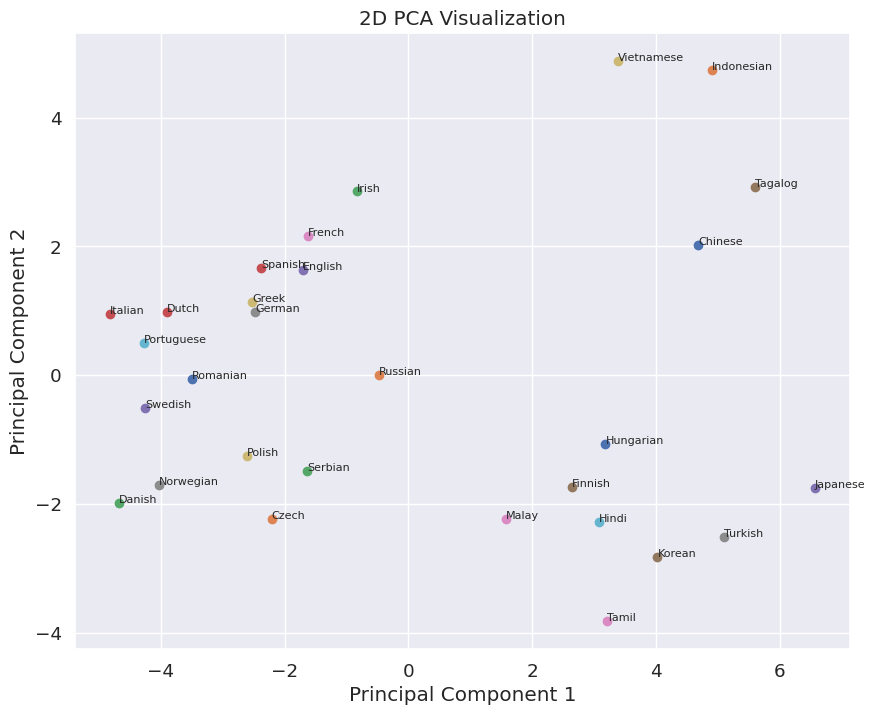

In [142]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 8))

pca = PCA(n_components=2)

# Fit the PCA model to the scaled data
df_features_sc = df_features_sc.fillna(0)
principal_components = pca.fit_transform(df_features_sc)

# Create a DataFrame with the principal components
df_PCA = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plot results
plt.figure(figsize=(10, 8))  # Adjust figure size if needed

# Scatter plot with labels
for i, language in enumerate(df_features['natlang']):
    x = df_PCA.loc[i, 'PC1']
    y = df_PCA.loc[i, 'PC2']
    plt.scatter(x, y)
    plt.text(x, y, language, fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

Overall, the groups visible on the PCA plot are similar to the groups given previously by the K means clustering algorithm. Somewhat remarkably, languages that are geographically and linguistically close to each other in real life are also close to each other on this plot, which only uses 30 grammatical features -- you can make out the Slavic language group and something of the Germanic and Austronesian language groups.

In the subsequent analysis, we will use the clusters in the unreduced dimensional space for better interpretability. At first glance, we only saw slight differences in performance by cluster:

,correct
cluster,
0.0,0.926904
1.0,0.964595
2.0,0.948080
3.0,0.943273
4.0,0.925832
5.0,0.939049
6.0,0.937944


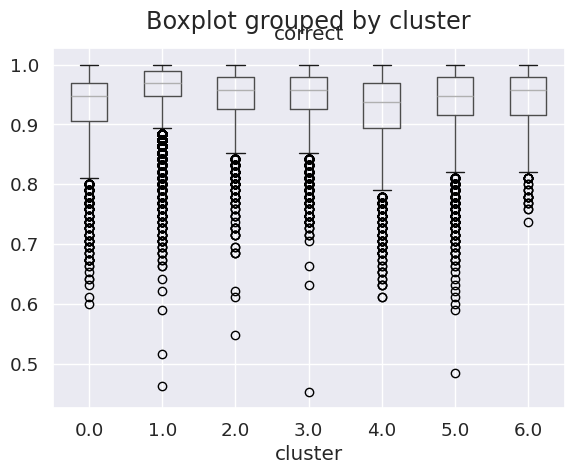

In [143]:
# Merge df_PCA with df_lang_sample
df_lang_sample = df_lang_sample.merge(df_eng_dist_concat.drop(columns='correct'), how='left', on='natlang')

# Create boxplots
df_lang_sample.boxplot(column='correct', by='cluster')

# Compare mean scores
df_lang_sample.groupby('cluster')['correct'].mean()

To statistically test for significant differences in the overall performance of the  clusters, we performed a one-way ANOVA and a post-hoc Tukey's test. The only group differences that we failed to reject were between clusters 0 and 4, 3 and 6, and 5 and 6.

In [144]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

# ANOVA
model = sm.ols(formula='correct ~ C(cluster)', data=df_lang_sample).fit()
anova_table = anova_lm(model, typ=2)
anova_table

# Post hoc tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df_lang_sample['correct'], df_lang_sample['cluster'])
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0377    0.0  0.0355  0.0398   True
   0.0    2.0   0.0212    0.0  0.0185  0.0238   True
   0.0    3.0   0.0164    0.0  0.0137  0.0191   True
   0.0    4.0  -0.0011 0.9404 -0.0038  0.0017  False
   0.0    5.0   0.0121    0.0  0.0097  0.0146   True
   0.0    6.0    0.011    0.0  0.0051   0.017   True
   0.0    nan   0.0143    0.0  0.0112  0.0175   True
   1.0    2.0  -0.0165    0.0 -0.0183 -0.0147   True
   1.0    3.0  -0.0213    0.0 -0.0232 -0.0195   True
   1.0    4.0  -0.0388    0.0 -0.0407 -0.0368   True
   1.0    5.0  -0.0255    0.0  -0.027 -0.0241   True
   1.0    6.0  -0.0267    0.0 -0.0323  -0.021   True
   1.0    nan  -0.0234    0.0 -0.0259 -0.0209   True
   2.0    3.0  -0.0048    0.0 -0.0073 -0.0024   True
   2.0    4.0  -0.0222    0.0 -0.0248 -0.0197   True
   2.0    5.0   -0.009    0.0 -0.0112 -0.0069 

However, this analysis overlooks whether there are significant differences between clusters in performance on each question. As the graph below shows, there appear to be substantial differences in the performance of each cluster on the test questions:

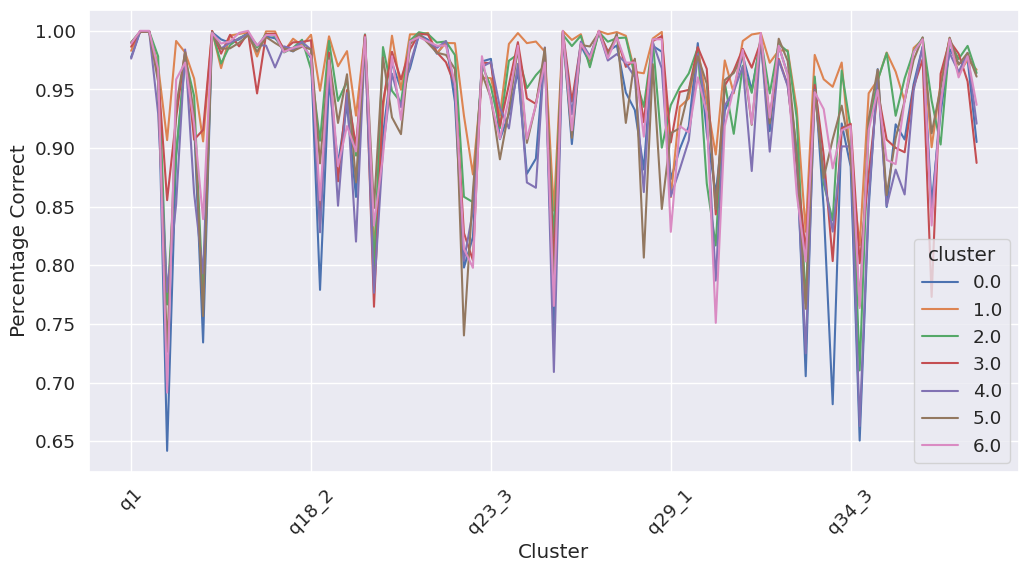

In [145]:
# Create index of each question column
question_index = df_lang_sample.columns[pd.Series(df_lang_sample.columns).str.startswith('q')]

# Create empty list
df_questions = pd.DataFrame()

# Iterate through questions to find correct % for each question based on clusters
for question in question_index:
  clust = df_lang_sample.groupby('cluster')[question].mean()
  df_questions = pd.concat([df_questions, clust],axis=1)

df_questions = df_questions.reset_index()
df_questions = df_questions.rename(columns={'index': 'cluster'})
df_questions = df_questions.melt(id_vars=['cluster'])

# Create barplot comparing scores of different clusters on questions
fig, ax = plt.subplots(figsize=(12, 6))
df_questions_pivot = df_questions.pivot_table(index='variable', columns='cluster', values='value')
df_questions_pivot.plot(kind='line', ax=ax)
plt.xlabel('Cluster')
plt.ylabel('Percentage Correct')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

We performed another ANOVA to officially test for differences in test question performance among groups.

In [146]:
model = sm.ols(formula='value ~ C(cluster)', data=df_questions).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(cluster),0.100096,6.0,3.949,0.000688
Residual,2.779736,658.0,NaN,NaN


This table shows that there are significant differences in the performance on specific test questions.

# **Modeling**

In [147]:
from sklearn.neighbors import KNeighborsRegressor

# k-nn regression function
x_train = df_lang_sample[question_cols].sample(frac=.5, random_state=1)
y_train = df_lang_sample['Distance'].sample(frac=.5, random_state=1)
#x_train = x_train.drop(y_train[y_train.isna()].index) # there's a NaN in here, so it was dropped.

x_test = df_lang_sample[question_cols].drop(x_train.index)
y_test = df_lang_sample['Distance'].drop(x_train.index)

# KNN regressor
def knn_error_model(k):
  model = KNeighborsRegressor(n_neighbors=k)
  model.fit(x_train, y_train)
  y_train_pred = model.predict(x_train)
  y_val_pred = model.predict(x_test)

  train_mae = (y_train.dropna() - y_train_pred).abs().mean()
  test_mae = (y_test - y_val_pred).abs().mean()

  return [train_mae, test_mae]

k_vals = np.arange(1,101)
mae_errors = [knn_error_model(k) for k in k_vals]

plt.plot(k_vals,mae_errors)
plt.legend(['Training Error','Validation Error'])
plt.xlabel('Values of k')
plt.ylabel('MAE')

ValueError: Input y contains NaN.

In [ ]:
k_errors = pd.DataFrame(mae_errors,columns=['Training Error','Validation Error'])
k_errors.sort_values(by='Validation Error') # minimized at k = 20 (not zero) for years_learning = 7